In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import torch
import importlib
import scib_metrics
from scib_metrics.benchmark import Benchmarker
import epipack as epk

In [2]:
epk.__version__

'0.1.0dev1'

In [3]:
pip list

Package                       Version
----------------------------- -------------
absl-py                       2.0.0
adjustText                    0.8
anndata                       0.9.2
annotated-types               0.5.0
annoy                         1.17.2
anyio                         3.7.1
appdirs                       1.4.4
arrow                         1.3.0
asttokens                     2.4.0
attrs                         23.1.0
backcall                      0.2.0
backoff                       2.2.1
backports.functools-lru-cache 1.6.5
bamnostic                     1.1.10
bbknn                         1.5.1
beautifulsoup4                4.12.2
biopython                     1.81
biothings-client              0.3.0
bleach                        6.0.0
blessed                       1.19.1
bokeh                         3.2.2
Brotli                        1.1.0
build                         0.10.0
CacheControl                  0.13.1
cached-property               1.5.2
certifi       

In [265]:
peak_1 = sc.read_h5ad("../../data/pbmc_batch/pbmc_5k_nextgem/peak_1.h5ad")
peak_2 = sc.read_h5ad("../../data/pbmc_batch/pbmc_10k_nextgem/peak_2.h5ad")
peak_3 = sc.read_h5ad("../../data/pbmc_batch/pbmc_10k_chromiumX/peak_3.h5ad")
peak_4 = sc.read_h5ad("../../data/pbmc_batch/pbmc_10k_Chromium_Controller/peak_4.h5ad")
peak_5 = sc.read_h5ad("../../data/pbmc_batch/pbmc_multiome/peak_6.h5ad")

In [266]:
genescore_mtx = sc.read_h5ad("../../data/pbmc_batch/pbmc_5b_genemtx.h5ad")

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [267]:
query = genescore_mtx[genescore_mtx.obs['batch_id']=='batch 2']

In [268]:
ref1 = genescore_mtx[genescore_mtx.obs['batch_id']=='batch 4']
ref2 = genescore_mtx[genescore_mtx.obs['batch_id']=='batch 6']

In [269]:
ref = sc.concat([ref1, ref2])

In [270]:
ref = ref[ref.obs.celltype != "B cell"]

In [271]:
peak_4 = peak_4[ref[ref.obs.batch_id == 'batch 4'].obs_names]

In [272]:
peak_5 = peak_5[ref[ref.obs.batch_id == 'batch 6'].obs_names]

In [273]:
query = query[query.obs.celltype != 'pDC']

In [274]:
peak_2 = peak_2[query.obs_names]

In [283]:
batch_id = [0 for _ in range(peak_4.shape[0])] + [1 for _ in range(peak_5.shape[0])] + [2 for _ in range(peak_2.shape[0])]

In [284]:
tmp = sc.concat([ref, query])

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [285]:
epi_integration = epk.ml.BridgeVAE(promoter_dt=tmp.layers['count'], enhancer_z = np.concatenate((peak_4.obsm['epipack_z_bce'], 
                                                                                                           peak_5.obsm['epipack_z_bce'],
                                                                                                           peak_2.obsm['epipack_z_bce'],
                                                                                                           #peak_5.obsm['epipack_z_bce']
                                                                                                           ), axis=0),
                         batch_id=batch_id, 
                         z_dim=50, batch_size=512, layer_num=2, reg_kl=1e-10, reg_mmd=1, reg_rec=1, reg_z_l2=0.1, use_batch_norm=True, use_layer_norm=False)

- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


In [286]:
epi_integration.train_model(nepochs=150, rec_loss='MSE')

Epochs: 100%|██████████| 150/150 [03:18<00:00,  1.32s/it, val_kl_loss=1.47e+5, val_loss_z_dist=0.56, val_mmd=0.082, val_rec_loss=1.6]   


In [287]:
z = epi_integration.get_latent()

In [289]:
tmp.obsm['z_tmp'] = z.detach().cpu().numpy()

In [184]:
ref.obsm['z_ref'] = z.detach().cpu().numpy()

In [200]:
batch_id = [0 for _ in range(peak_2.shape[0])]# + [1 for _ in range(peak_2.shape[0])]

In [240]:
epi_query = epk.ml.VAE_MAPPING(promoter_dt=query.layers['count'], enhancer_z = peak_2.obsm['epipack_z_bce'],
                           ref_embedding=ref.obsm['z_ref'],
                         batch_id=batch_id, 
                         z_dim=50, batch_size=256, layer_num=2, reg_kl=1e-10, reg_mmd=1, reg_mmd_inter =0.1, reg_rec=1, reg_z_l2=0.01, use_batch_norm=True, dropout_rate = 0,use_layer_norm=False)

- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


In [241]:
def query_model_initial(query_model = None, ref_model_param = None, query_batch_num=None, gene_feature_num = 3000, latent_embedding_dim = 50):
    
    ref_para = ref_model_param
    device = ref_para['Encoder.fc.fc_layers.Layer 0.0.weight'].device

    query_para = ref_para

    #initial first encoder layer
    feature_weight = ref_para['Encoder.fc.fc_layers.Layer 0.0.weight'][:,:gene_feature_num]
    new_batch_weight = np.random.randn(feature_weight.shape[0], query_batch_num) / np.sqrt(feature_weight.shape[0])
    new_batch_weight = torch.from_numpy(new_batch_weight).float().to(device)
    init_weight_en = torch.cat([feature_weight, new_batch_weight], dim=1)
    ref_model_param['Encoder.fc.fc_layers.Layer 0.0.weight']

    query_para['Encoder.fc.fc_layers.Layer 0.0.weight'] = init_weight_en

    #initial first decoder layer
    latent_weight = ref_para['Decoder.fc.fc_layers.Layer 0.0.weight'][:,:latent_embedding_dim]
    new_batch_weight = np.random.randn(latent_weight.shape[0], query_batch_num) / np.sqrt(latent_weight.shape[0])
    new_batch_weight = torch.from_numpy(new_batch_weight).float().to(device)
    init_weight_de = torch.cat([latent_weight, new_batch_weight], dim=1)

    query_para['Decoder.fc.fc_layers.Layer 0.0.weight'] = init_weight_de

    query_model.load_state_dict(query_para)
    
    fix = ['Layer 1', 'mean_layer', 'var_layer']
    for k,v in query_model.named_parameters():
        v.requires_grad = True
        if any(x in k for x in fix):
            v.requires_grad = False

    return query_model
    

In [242]:
query_model = query_model_initial(epi_query, epi_integration.state_dict(), 1)

In [243]:
epi_query.train_model(nepochs=150, rec_loss='MSE')

Epochs: 100%|██████████| 150/150 [01:44<00:00,  1.44it/s, val_kl_loss=1.11e+5, val_loss_z_dist=0.65, val_mmd=3.16e-5, val_mmd_inter=0.0362, val_rec_loss=1.58] 


In [244]:
z2 = epi_query.get_latent()

In [245]:
query.obsm['z_query'] = z2.detach().cpu().numpy()

In [246]:
tmp = sc.concat([ref, query])

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [247]:
tmp.obsm['z_tmp'] = np.concatenate([ref.obsm['z_ref'], query.obsm['z_query']])

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


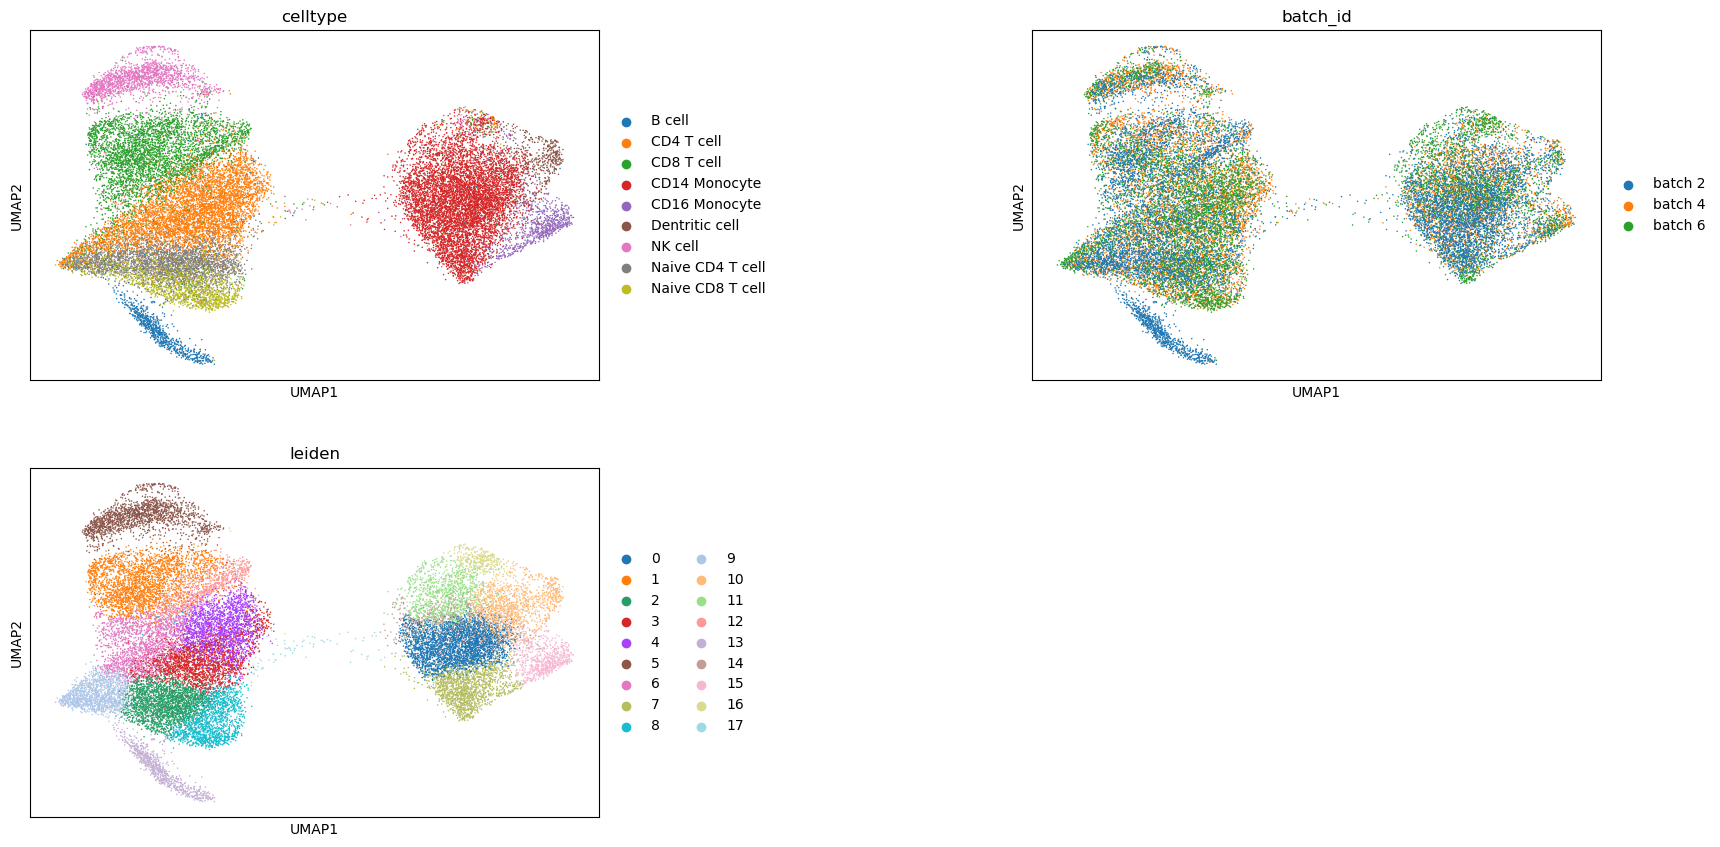

In [290]:
sc.pp.neighbors(tmp, n_neighbors=30, use_rep='z_tmp')
sc.tl.umap(tmp)
sc.tl.leiden(tmp, resolution=1.5)
sc.pl.umap(tmp, color=['celltype', 'batch_id','leiden'], ncols=2, wspace=0.6)

### total integration

In [74]:
batch_id = [0 for _ in range(peak_4.shape[0])] + [1 for _ in range(peak_5.shape[0])] + [2 for _ in range(peak_2.shape[0])]

In [75]:
epi_integration = epk.ml.BridgeVAE(promoter_dt=tmp.layers['count'], enhancer_z = np.concatenate((peak_4.obsm['epipack_z_bce'], 
                                                                                                           peak_5.obsm['epipack_z_bce'], 
                                                                                                           peak_2.obsm['epipack_z_bce']
                                                                                                           #peak_4.obsm['epipack_z_bce'],
                                                                                                           #peak_5.obsm['epipack_z_bce']
                                                                                                           ), axis=0),
                         batch_id=batch_id, 
                         z_dim=50, batch_size=512, layer_num=2, reg_kl=1e-10, reg_mmd=1, reg_rec=1, reg_z_l2=0.1, use_batch_norm=True, use_layer_norm=False)

- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


In [76]:
epi_integration.train_model(nepochs=150, rec_loss='MSE')

Epochs: 100%|██████████| 150/150 [03:29<00:00,  1.40s/it, val_kl_loss=1.47e+5, val_loss_z_dist=0.565, val_mmd=0.0868, val_rec_loss=1.44]


In [77]:
z = epi_integration.get_latent()

In [78]:
tmp.obsm['denovo'] = z.detach().cpu().numpy()

In [72]:
import scib_metrics
from scib_metrics.benchmark import Benchmarker

In [73]:
biocon = scib_metrics.benchmark.BioConservation(isolated_labels=False, nmi_ari_cluster_labels_leiden=True, nmi_ari_cluster_labels_kmeans=False, silhouette_label=True, clisi_knn=False)
batchcor = scib_metrics.benchmark.BatchCorrection(silhouette_batch=True, ilisi_knn=True, kbet_per_label=True, graph_connectivity=False, pcr_comparison=False)

In [81]:
bm = Benchmarker(
    tmp,
    batch_key="batch_id",
    label_key="celltype",
    embedding_obsm_keys=["denovo","z_tmp"],
    bio_conservation_metrics=biocon,
    batch_correction_metrics = batchcor,
    n_jobs=1
)

In [82]:
bm.benchmark()

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
Computing neighbors:   0%|          | 0/2 [00:00<?, ?it/s]/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/numba/core/types/functions.py:310: NumbaPendingDeprecationWarning: The 'old_style' error capturing is deprecated and will be replaced by `new_style` in a future release.
  if (utils.use_new_style_errors() and not
Embeddings:   0%|          | 0/2 [00:00<?, ?it/s]No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     pDC consists of a single batch or is too small. Skip.                                                     


Embeddings:  50%|█████     | 1/2 [01:08<01:08, 68.10s/it]

INFO     pDC consists of a single batch or is too small. Skip.                                                     


Embeddings: 100%|██████████| 2/2 [02:13<00:00, 66.86s/it]


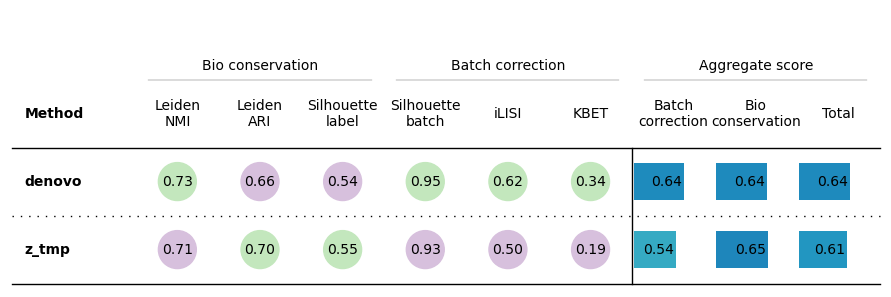

In [83]:
bm.plot_results_table(min_max_scale=False)

In [86]:
import scvi

scvi_data = tmp.copy()
scvi.model.SCVI.setup_anndata(scvi_data, layer="count", batch_key="batch_id")
model = scvi.model.SCVI(scvi_data, n_layers=2, n_latent=30, gene_likelihood="nb")
model.train()
tmp.obsm['scvi_1'] = model.get_latent_representation()

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 304/304: 100%|██████████| 304/304 [10:16<00:00,  2.04s/it, v_num=1, train_loss_step=2.16e+3, train_loss_epoch=2.1e+3] 

`Trainer.fit` stopped: `max_epochs=304` reached.


Epoch 304/304: 100%|██████████| 304/304 [10:16<00:00,  2.03s/it, v_num=1, train_loss_step=2.16e+3, train_loss_epoch=2.1e+3]


In [87]:
bm = Benchmarker(
    tmp,
    batch_key="batch_id",
    label_key="celltype",
    embedding_obsm_keys=["denovo","z_tmp","scvi_1"],
    bio_conservation_metrics=biocon,
    batch_correction_metrics = batchcor,
    n_jobs=1
)

In [88]:
bm.benchmark()

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

INFO     pDC consists of a single batch or is too small. Skip.                                                     


Embeddings:  33%|███▎      | 1/3 [00:55<01:50, 55.00s/it]

INFO     pDC consists of a single batch or is too small. Skip.                                                     


Embeddings:  67%|██████▋   | 2/3 [01:56<00:58, 58.95s/it]

INFO     pDC consists of a single batch or is too small. Skip.                                                     


Embeddings: 100%|██████████| 3/3 [02:31<00:00, 50.65s/it]


In [8]:
tmp.write_h5ad("reference_mapping1031.h5ad")

In [2]:
tmp = sc.read_h5ad('reference_mapping1031.h5ad')

In [7]:
tmp.obs_names_make_unique()

In [14]:
pd.DataFrame(tmp.obs.batch_id).to_csv("ref_mapping_bid.csv")

In [7]:
tmp.obs.batch_id

AAACGAAAGAGAGGTA-1    batch 4
AAACGAAAGCAGGAGG-1    batch 4
AAACGAAAGGAAGAAC-1    batch 4
AAACGAAAGTCGACCC-1    batch 4
AAACGAACAAGCACTT-1    batch 4
                       ...   
TTTGTGTTCCTAAGTG-1    batch 2
TTTGTGTTCCTGGAAT-1    batch 2
TTTGTGTTCCTTTGAT-1    batch 2
TTTGTGTTCGCATACA-1    batch 2
TTTGTGTTCTCGACAA-1    batch 2
Name: batch_id, Length: 26280, dtype: category
Categories (3, object): ['batch 2', 'batch 4', 'batch 6']

In [9]:
tmp[tmp.obs.batch_id.isin(['batch 4','batch 6'])]

View of AnnData object with n_obs × n_vars = 17745 × 3000
    obs: 'celltype', 'batch_id', 'leiden', 'cell_type_new'
    uns: 'batch_id_colors', 'celltype_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'denovo', 'epipack', 'scvi_1', 'z_tmp'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

### oor

In [291]:
ref = tmp[tmp.obs.batch_id.isin(['batch 4','batch 6'])]

In [292]:
query = tmp[tmp.obs.batch_id.isin(['batch 2'])]

In [136]:
query = query[query.obs.celltype != 'pDC']

In [293]:
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import poisson
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

le = LabelEncoder()
y = le.fit_transform(ref.obs.celltype)

In [211]:
neigh = KNeighborsClassifier(n_neighbors=15)  
neigh.fit(ref.obsm['z_ref'], y)
querylabel = neigh.predict(query.obsm['z_query'])

In [212]:
querylabel = le.inverse_transform(querylabel)

In [372]:
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score, roc_auc_score

In [214]:
f1_score(query.obs['celltype'], querylabel, average='weighted')

0.7114853933320657

In [74]:
neigh = KNeighborsClassifier(n_neighbors=15)  
neigh.fit(ref.X, y)
querylabel = neigh.predict(query.X)

In [75]:
querylabel = le.inverse_transform(querylabel)

In [76]:
f1_score(query.obs['celltype'], querylabel, average='macro')

0.43006146373027204

In [33]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(ref.obsm['z_tmp'], ref.obs['celltype'])

SVC(probability=True)

In [34]:
ct = clf.predict(query.obsm['z_tmp'])

In [35]:
f1_score(query.obs['celltype'], ct, average='weighted')

0.7803583634125135

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


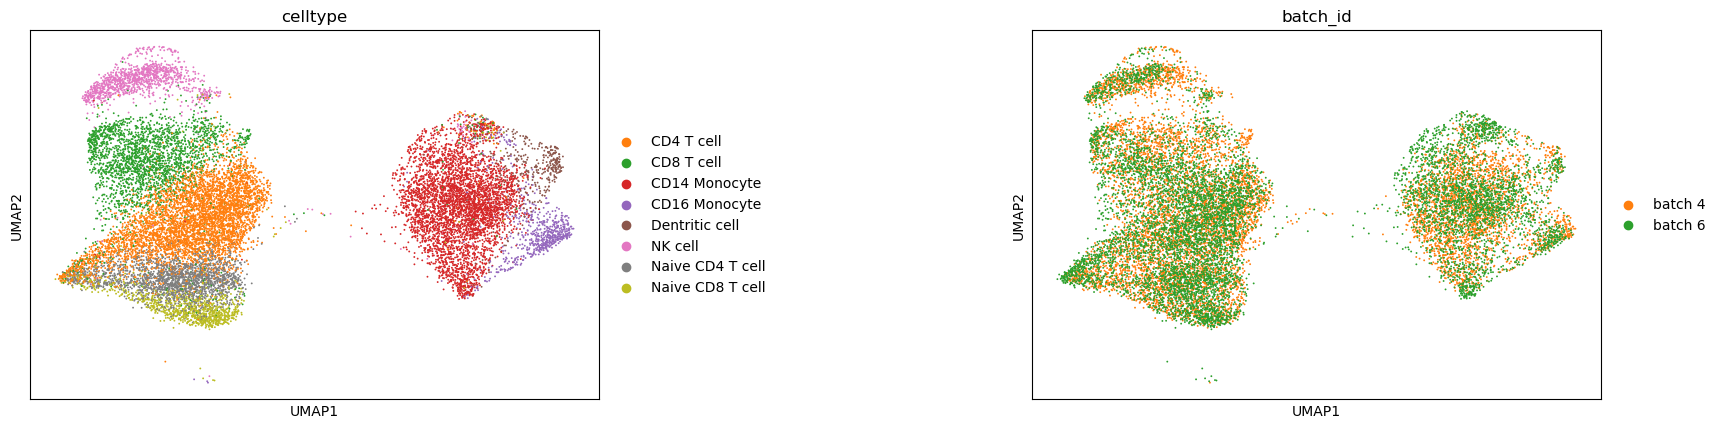

In [296]:
sc.pl.umap(ref, color=['celltype', 'batch_id'], ncols=2, wspace=0.6)

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


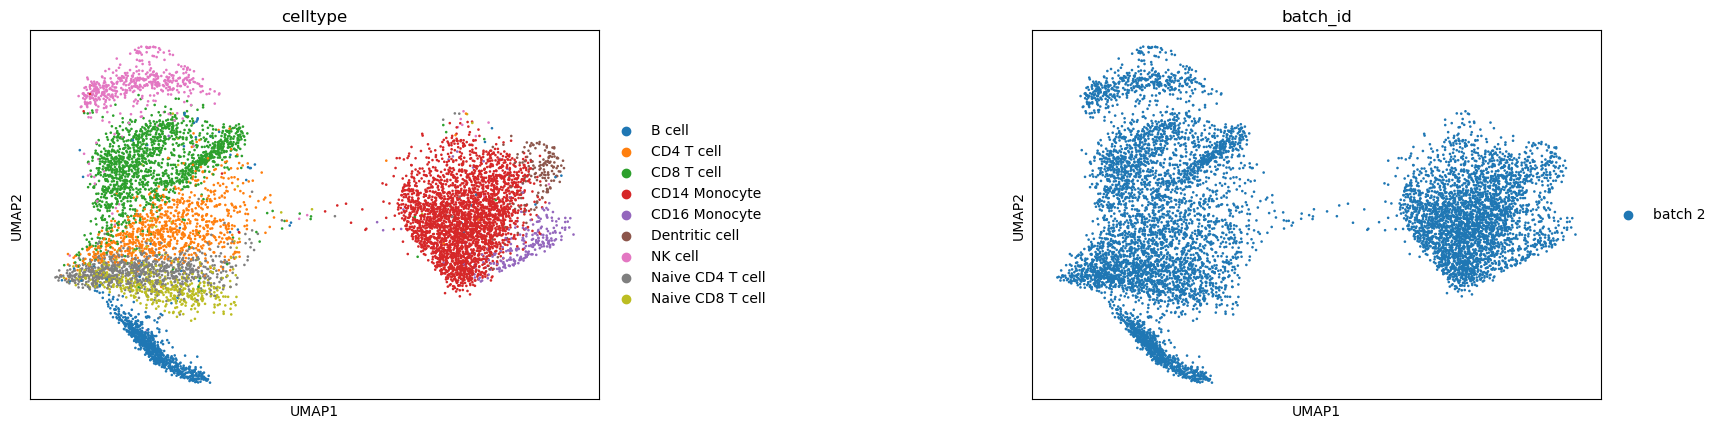

In [298]:
sc.pl.umap(query, color=['celltype', 'batch_id'], ncols=2, wspace=0.6)

In [300]:
init_mu = []
init_cov_inv = []
        
## parameter estimation of class-condition gaussian 
for i in np.unique(y):
    class_i_data = ref.obsm['z_tmp'][np.where(y == i)]
    class_i_mean = np.mean(class_i_data, axis=0, keepdims=True)
    class_i_norm = class_i_data - class_i_mean
    class_i_cov = np.matmul(class_i_norm.T, class_i_norm)/(class_i_norm.shape[0]-1)

    init_mu.append(class_i_mean)
    init_cov_inv.append(np.linalg.inv(class_i_cov))

#dist_mat_ref = np.zeros((ref.obsm['z_tmp'].shape[0], len(np.unique(y))))

## in-class distance distribution
#for i in range(len(init_mu)):
#    ref_norm = ref.obsm['z_tmp'] - init_mu[i]
#    ref_dist_i = np.matmul(np.matmul(ref_norm, init_cov_inv[i]), ref_norm.T)
#    dist_mat_ref[:,i] = np.diag(ref_dist_i)

In [304]:
neigh = KNeighborsClassifier(n_neighbors=15)  
neigh.fit(ref.obsm['z_tmp'], y)
querylabel = neigh.predict(query.obsm['z_tmp'])

In [305]:
dist_mat_query = np.zeros((query.obsm['z_tmp'].shape[0], len(np.unique(y))))
for i in range(len(init_mu)):
    query_norm = query.obsm['z_tmp'] - init_mu[i]
    query_dist_i = np.matmul(np.matmul(query_norm, init_cov_inv[i]), query_norm.T)
    dist_mat_query[:,i] = np.diag(query_dist_i)

In [306]:
from scipy.stats import chi2

In [307]:
def cal_dist_query(query_data, label, mu_set, cov_set):

    '''
    mu_set: 输入前面那个函数的 init_mu
    cov_set: 输入前面那个函数的 init_cov_inv
    query_data: 输入那个sqtz的numpy矩阵
    label: 输入sqtz的label [1,1,1,1,1,...,1,1]
    '''        
    dist_mat_query = np.zeros((query_data.shape[0], len(np.unique(label))))
    for i in range(len(mu_set)):
        query_norm = query_data - mu_set[i]
        query_dist_i = np.matmul(np.matmul(query_norm, cov_set[i]), query_norm.T)
        dist_mat_query[:,i] = np.diag(query_dist_i)

    return dist_mat_query

In [562]:
reject_cell_list = []
prob_score = []

df = query.obsm['z_tmp'].shape[1]

for i in range(query.obsm['z_tmp'].shape[0]):
    raw_label = querylabel[i]
    dist_i_c = dist_mat_query[i][raw_label]

    #min_dist_label = np.argmin(dist_mat_query[i])
    #dist_i_c_gau = dist_mat_query[i][min_dist_label]
    q = 1-chi2.cdf(dist_i_c, df)

    if q<5e-4:
        reject_cell_list.append(i)
    prob_score.append(q)

In [555]:
len(reject_cell_list)

1140

In [542]:
final_cell_type = le.inverse_transform(querylabel)
final_cell_type[reject_cell_list] = 'Uncertain'

In [543]:
query.obs['predicted_label'] = final_cell_type

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


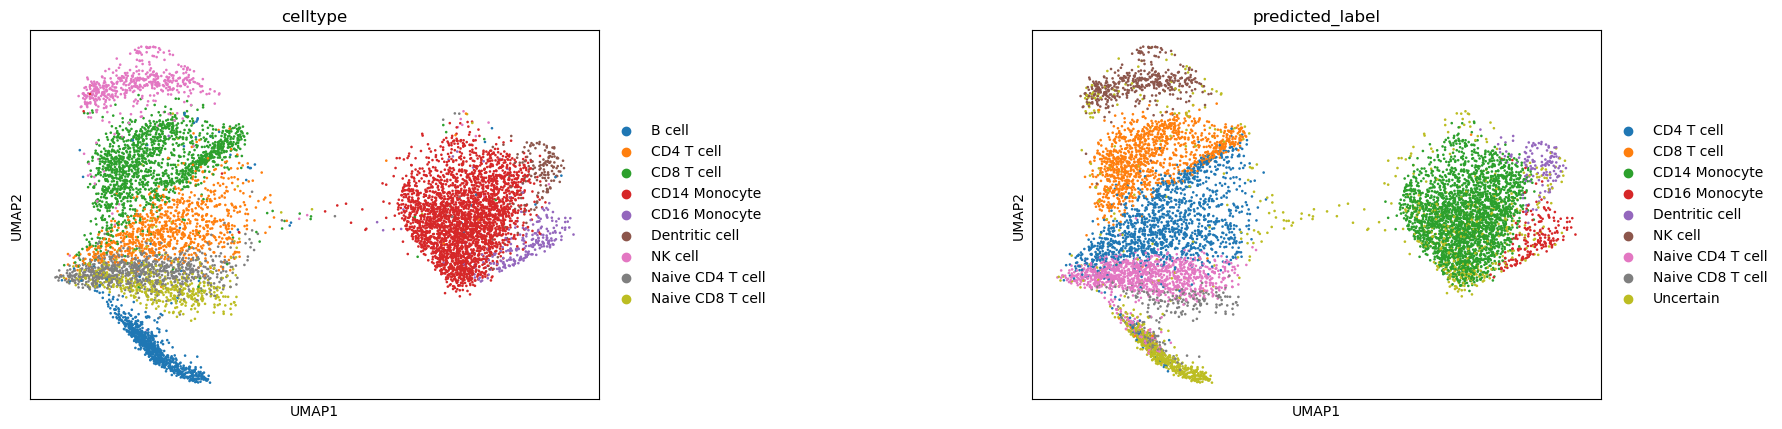

In [544]:
sc.pl.umap(query, color=['celltype', 'predicted_label'], ncols=2, wspace=0.6)

In [500]:
query.write_h5ad('query_b_cell.h5ad')

In [501]:
ref.write_h5ad("ref_b_cell.h5ad")

In [547]:
pd.DataFrame(query.obs['predicted_label']).to_csv("query_b_cell_pred.csv")

In [545]:
oor = query[query.obs.celltype == 'B cell']

In [546]:
len(np.where(oor.obs['predicted_label'] == 'Uncertain')[0])

550

In [565]:
pd.DataFrame(query.obs['prob_score']).to_csv("query_b_cell_probscore.csv")

In [563]:
query.obs['prob_score'] = prob_score

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


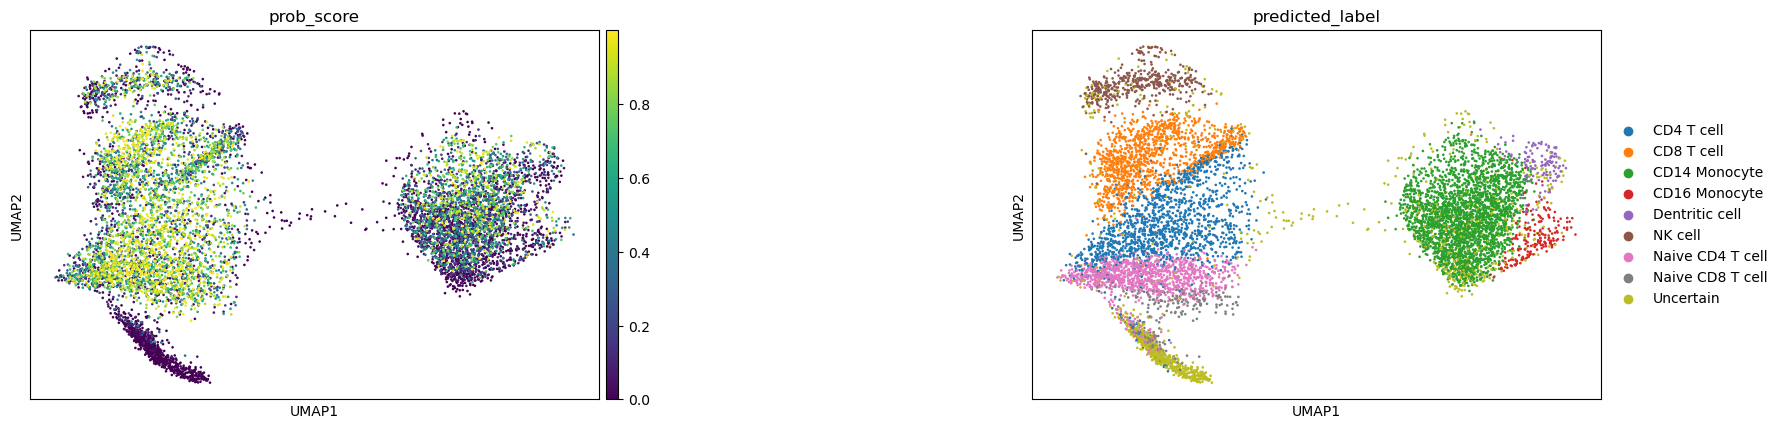

In [564]:
sc.pl.umap(query, color=['prob_score', 'predicted_label'], ncols=2, wspace=0.6)

In [520]:
id = np.zeros(len(query))

In [521]:
id[np.where(query.obs.celltype == 'B cell')] = 1

In [522]:
id_test = []
for i in list(query.obs['predicted_label']):
    if i == 'Uncertain':
        id_test.append(1)
    else:
        id_test.append(0)

In [523]:
id_test = np.array(id_test)

In [524]:
np.sum(id_test)

1843

In [525]:
roc_auc_score(id, id_test)

0.8469712099431954

In [406]:
from sklearn.svm import SVC

clf = SVC(probability=True)
clf.fit(ref.obsm['z_tmp'], ref.obs['celltype'])

SVC(probability=True)

In [409]:
ct = clf.predict_proba(query.obsm['z_tmp'])

In [481]:
id_test_svm = []
for i in ct:
    if np.max(i) < 0.7:
        id_test_svm.append(1)
    else:
        id_test_svm.append(0)


In [482]:
id_test_svm = np.array(id_test_svm)

In [483]:
np.sum(id_test_svm)

1831

In [484]:
roc_auc_score(id, id_test_svm)

0.7472844872622451

In [485]:
from sklearn.metrics import confusion_matrix

In [526]:
cnf_matrix = confusion_matrix(id, id_test)

In [527]:
cnf_matrix

array([[6509, 1150],
       [ 128,  693]])

In [528]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

In [529]:
TPR

array([0.84984985, 0.84409257])

In [551]:
prob_score = 10*np.sqrt(prob_score)

In [74]:
ref.obs['prob_score'] = prob_score

In [116]:
ref

AnnData object with n_obs × n_vars = 17745 × 3000
    obs: 'celltype', 'batch_id', 'leiden', 'cell_type_new', 'prob_score'
    uns: 'neighbors', 'umap', 'celltype_colors'
    obsm: 'X_pca', 'X_umap', 'epipack', 'z_ref'
    layers: 'count'
    obsp: 'distances', 'connectivities'

In [127]:
keep_dim = np.delete(np.arange(0,len(ref)), reject_cell_list)

In [128]:
train_ref = ref[keep_dim]

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


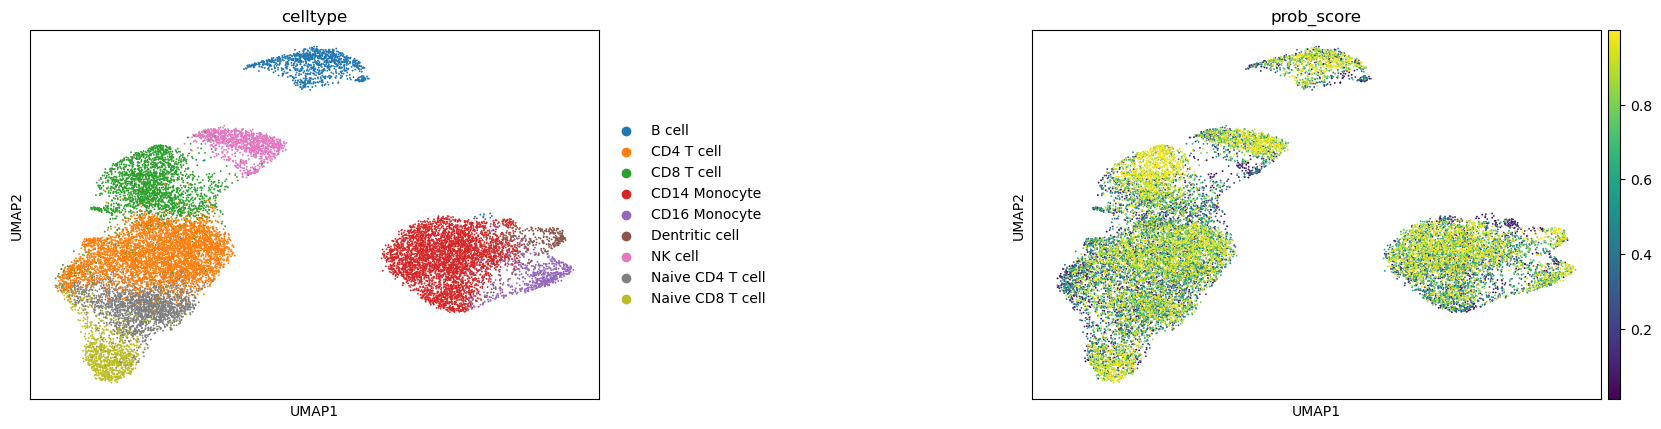

In [129]:
sc.pp.neighbors(train_ref, n_neighbors=30, use_rep='z_ref')
sc.tl.umap(train_ref)
#sc.tl.leiden(genescore_mtx, resolution=1.5)
sc.pl.umap(train_ref, color=['celltype', 'prob_score'], ncols=2, wspace=0.6)

In [73]:
dist_mat_ref[np.where(y==4)][:,4].shape

(2461,)

(array([ 1.,  0.,  0.,  1.,  1.,  4.,  4.,  8.,  7.,  7., 17., 12., 19.,
        24., 35., 35., 43., 40., 41., 57., 59., 59., 67., 64., 62., 74.,
        71., 66., 82., 81., 68., 69., 55., 68., 61., 66., 53., 57., 49.,
        37., 50., 46., 39., 33., 37., 34., 30., 28., 31., 23., 25., 22.,
        17., 22., 22., 21., 16., 19., 16., 20., 12., 17., 18.,  6., 12.,
        11., 10.,  6.,  5.,  9.,  6.,  7., 10.,  9.,  4.,  2.,  1.,  8.,
         4.,  1.,  2.,  4.,  2.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,
         0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([ 14.50993443,  15.53144725,  16.55296007,  17.57447289,
         18.59598572,  19.61749854,  20.63901136,  21.66052419,
         22.68203701,  23.70354983,  24.72506266,  25.74657548,
         26.7680883 ,  27.78960113,  28.81111395,  29.83262677,
         30.8541396 ,  31.87565242,  32.89716524,  33.91867806,
         34.94019089,  35.96170371,  36.98321653,  38.00472936,
         39.02624218,  40.047755  ,  41.06926783, 

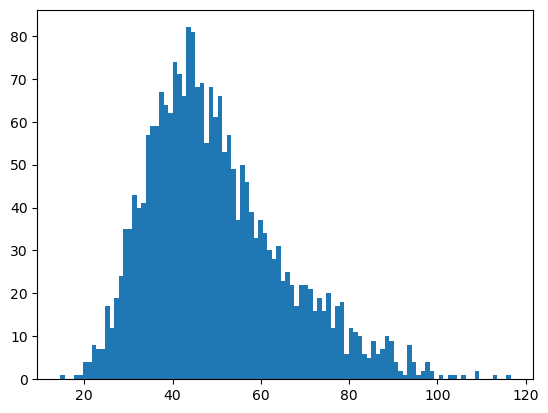

In [99]:
import matplotlib.pyplot as plt
plt.hist(dist_mat_ref[np.where(train_y==4)][:,4], bins=100)

(array([ 4.,  4.,  7.,  2.,  8., 22., 18., 32., 28., 48., 47., 51., 54.,
        59., 69., 66., 62., 55., 52., 49., 48., 40., 32., 32., 19., 16.,
        17., 14., 12.,  8.,  7.,  7.,  3.,  3.,  1.,  0.,  1.,  1.,  0.,
         2.]),
 array([24.88790395, 26.44646971, 28.00503547, 29.56360123, 31.12216699,
        32.68073275, 34.23929851, 35.79786428, 37.35643004, 38.9149958 ,
        40.47356156, 42.03212732, 43.59069308, 45.14925884, 46.7078246 ,
        48.26639036, 49.82495612, 51.38352188, 52.94208765, 54.50065341,
        56.05921917, 57.61778493, 59.17635069, 60.73491645, 62.29348221,
        63.85204797, 65.41061373, 66.96917949, 68.52774525, 70.08631101,
        71.64487678, 73.20344254, 74.7620083 , 76.32057406, 77.87913982,
        79.43770558, 80.99627134, 82.5548371 , 84.11340286, 85.67196862,
        87.23053438]),
 <BarContainer object of 40 artists>)

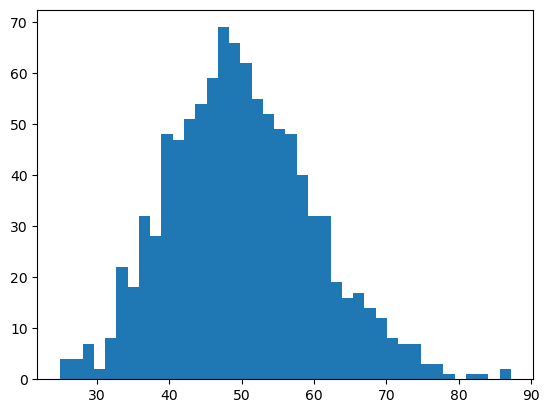

In [102]:
r = chi2.rvs(49.953, size=1000)
plt.hist(r, bins=40)

In [23]:
classifier = epk.ml.global_oor_query(train_data=ref.obsm['z_ref'], query_data=query1.obsm['z_query'], label=ref.obs['celltype'])

- Classifier prepared


In [55]:
query_label, prb = classifier.annotate(k=15, confidence_threshold=0.01, adjust_by_dist=False, adjust_threshold=0.02)

- Running kNN classifier with k = 15 ...
- kNN complete
- Gaussian distance calculating...
- Gaussian distance complete
- Start detecting global out-of-reference cells...
- Annotation complete


In [56]:
query1.obs['predicted_type'] = query_label

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


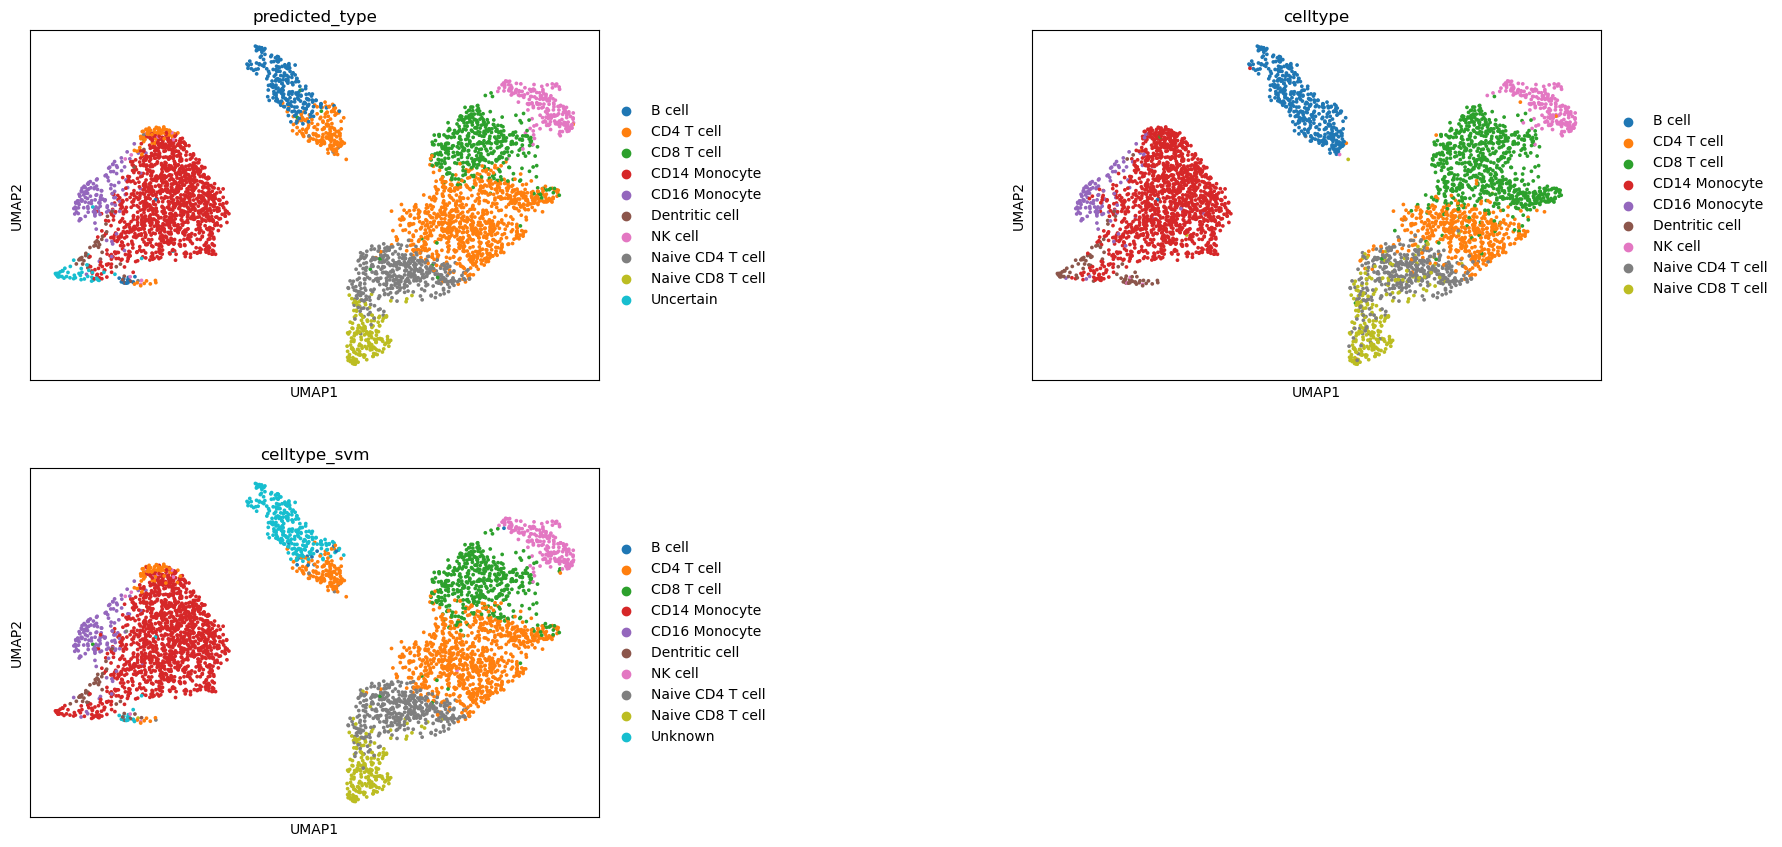

In [61]:
sc.pp.neighbors(query1, n_neighbors=10, use_rep='z_query')
sc.tl.umap(query1)
#sc.tl.leiden(genescore_mtx, resolution=1.5)
sc.pl.umap(query1, color=['predicted_type','celltype', 'celltype_svm'], ncols=2, wspace=0.6)

In [36]:
from sklearn.svm import SVC

clf = SVC(probability=True)
clf.fit(ref.obsm['z_ref'], ref.obs['celltype'])

SVC(probability=True)

In [37]:
ct = clf.predict(query1.obsm['z_query'])

In [38]:
prob = clf.predict_proba(query1.obsm['z_query'])

In [41]:
reject_list = []

In [58]:
for i in range(len(prob)):
    if np.argmax(prob[i]) < 0.8:
        reject_list.append(i)

In [59]:
ct[reject_list] = 'Unknown'

In [60]:
query1.obs['celltype_svm'] = ct

In [195]:
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score

In [289]:
query_label_2 = query_label[query_label != 'Uncertain']

In [290]:
print('Weighted f1-score', f1_score(query2.obs['celltype'][np.where(query_label != 'Uncertain')[0]], query_label_2, average='weighted'))

Weighted f1-score 0.7622245297267648


In [177]:
query_label[np.where(query2.obs.celltype=='pDC')]

array(['Unknow', 'Unknow', 'Naive CD8 T cell', 'B cell', 'Unknow',
       'Naive CD4 T cell', 'NK cell', 'Unknow', 'Unknow', 'Unknow',
       'Unknow', 'CD8 T cell', 'Naive CD8 T cell', 'Unknow', 'Unknow',
       'Unknow', 'B cell', 'Unknow', 'Naive CD8 T cell', 'B cell',
       'Unknow', 'Unknow', 'Unknow', 'Naive CD8 T cell',
       'Naive CD8 T cell', 'B cell', 'Unknow', 'Unknow', 'Unknow',
       'Naive CD8 T cell', 'Unknow', 'Unknow', 'B cell', 'Unknow',
       'Unknow', 'Unknow', 'Unknow', 'Unknow', 'Unknow', 'Unknow',
       'Naive CD8 T cell', 'Unknow', 'Unknow', 'Unknow', 'Unknow',
       'Unknow', 'Unknow', 'CD4 T cell', 'B cell', 'Unknow', 'Unknow',
       'B cell', 'B cell', 'Unknow', 'Unknow'], dtype=object)

In [178]:
np.unique(query_label)

array(['B cell', 'CD14 Monocyte', 'CD16 Monocyte', 'CD4 T cell',
       'CD8 T cell', 'Dentritic cell', 'NK cell', 'Naive CD4 T cell',
       'Naive CD8 T cell', 'Unknow'], dtype=object)

In [179]:
len(query_label[query_label=='Unknow'])

1143

(array([6.330e+02, 1.441e+03, 1.127e+03, 0.000e+00, 1.457e+03, 2.073e+03,
        0.000e+00, 1.555e+03, 2.470e+02, 2.000e+00]),
 array([3.35820260e-12, 9.16160525e-02, 1.83232105e-01, 2.74848158e-01,
        3.66464210e-01, 4.58080263e-01, 5.49696315e-01, 6.41312368e-01,
        7.32928420e-01, 8.24544473e-01, 9.16160525e-01]),
 <BarContainer object of 10 artists>)

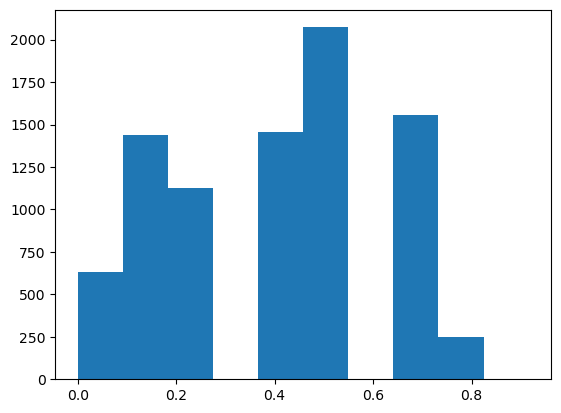

In [184]:
plt.hist(prb)

In [153]:
query2.obs.celltype

AAACGAAAGAGCTGTG-1       CD14 Monocyte
AAACGAAAGCCTCGCA-1              B cell
AAACGAAAGCGAGCTA-1       CD14 Monocyte
AAACGAAAGCGCCTAC-1             NK cell
AAACGAAAGGGAGTTC-1       CD14 Monocyte
                            ...       
TTTGTGTTCCTAAGTG-1    Naive CD4 T cell
TTTGTGTTCCTGGAAT-1       CD14 Monocyte
TTTGTGTTCCTTTGAT-1    Naive CD8 T cell
TTTGTGTTCGCATACA-1       CD14 Monocyte
TTTGTGTTCTCGACAA-1              B cell
Name: celltype, Length: 8535, dtype: category
Categories (10, object): ['B cell', 'CD4 T cell', 'CD8 T cell', 'CD14 Monocyte', ..., 'NK cell', 'Naive CD4 T cell', 'Naive CD8 T cell', 'pDC']